In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
import pickle

from tqdm import tqdm

from collections import Counter

from linearization.analyzer import SAELinearizer

In [42]:
# Hyperparameters
# SAE_NUM = "0_8192"
SAE_NUM = "1_32768"
# SAE_NUM = "2_32768"


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NORMALIZE_SAE_VECS = False
# NORMALIZE_SAE_VECS = True

# Pythia layers
Making sense of SAE-SAE connections

In [4]:
if os.path.exists(f"../data/pickled_linearizers/pythia_{SAE_NUM}.pkl"):
    lin = pickle.load(open(f"../data/pickled_linearizers/pythia_{SAE_NUM}.pkl", "rb"))
else:
    lin = SAELinearizer(
        model_name="pythia-70m",
        sae_names=[f"{x}/{SAE_NUM}" for x in [0, 1, 2, 3, 4, 5]],
        layers=[0, 1, 2, 3, 4, 5],
        dataset_name="NeelNanda/pile-10k",
        act_name="mlp_out",
        num_batches=100,
        # run_analysis=False,
    )
    with open(f"../data/pickled_linearizers/pythia_{SAE_NUM}.pkl", "wb") as f:
        pickle.dump(lin, f)

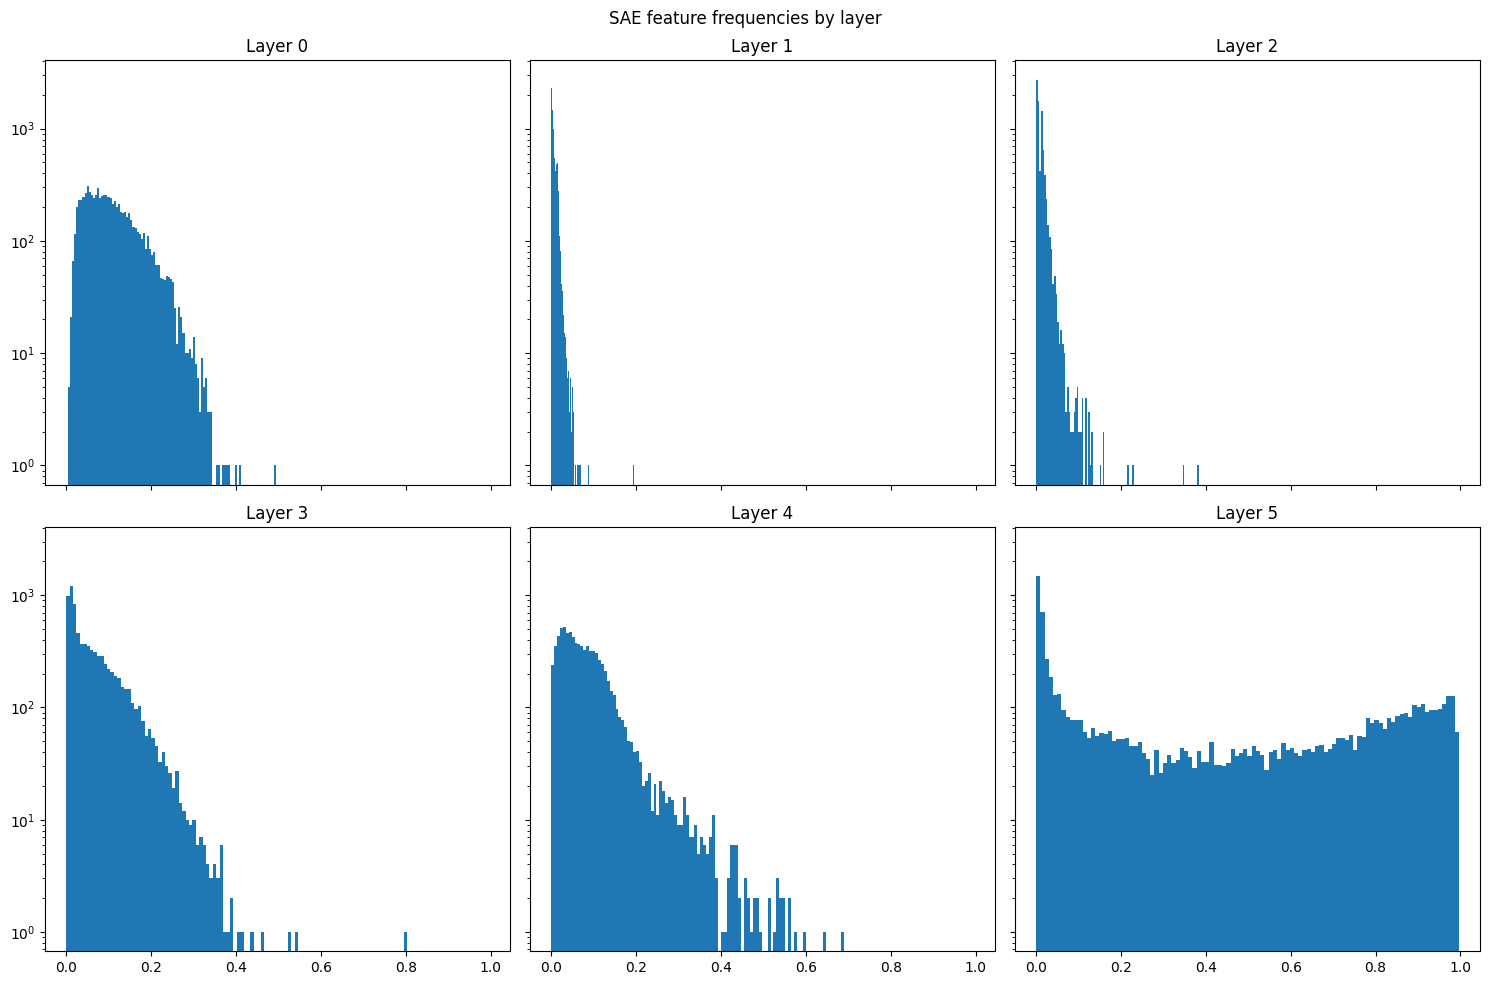

In [5]:
# Feature distributions
fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)
ax = ax.flatten()
for dim in range(6):
    ax[dim].hist(lin.frequencies[f"{dim}/{SAE_NUM}"].cpu().numpy(), bins=100)
    ax[dim].set_title(f"Layer {dim}")
    ax[dim].set_yscale("log")

plt.suptitle("SAE feature frequencies by layer")
plt.tight_layout()
plt.show()

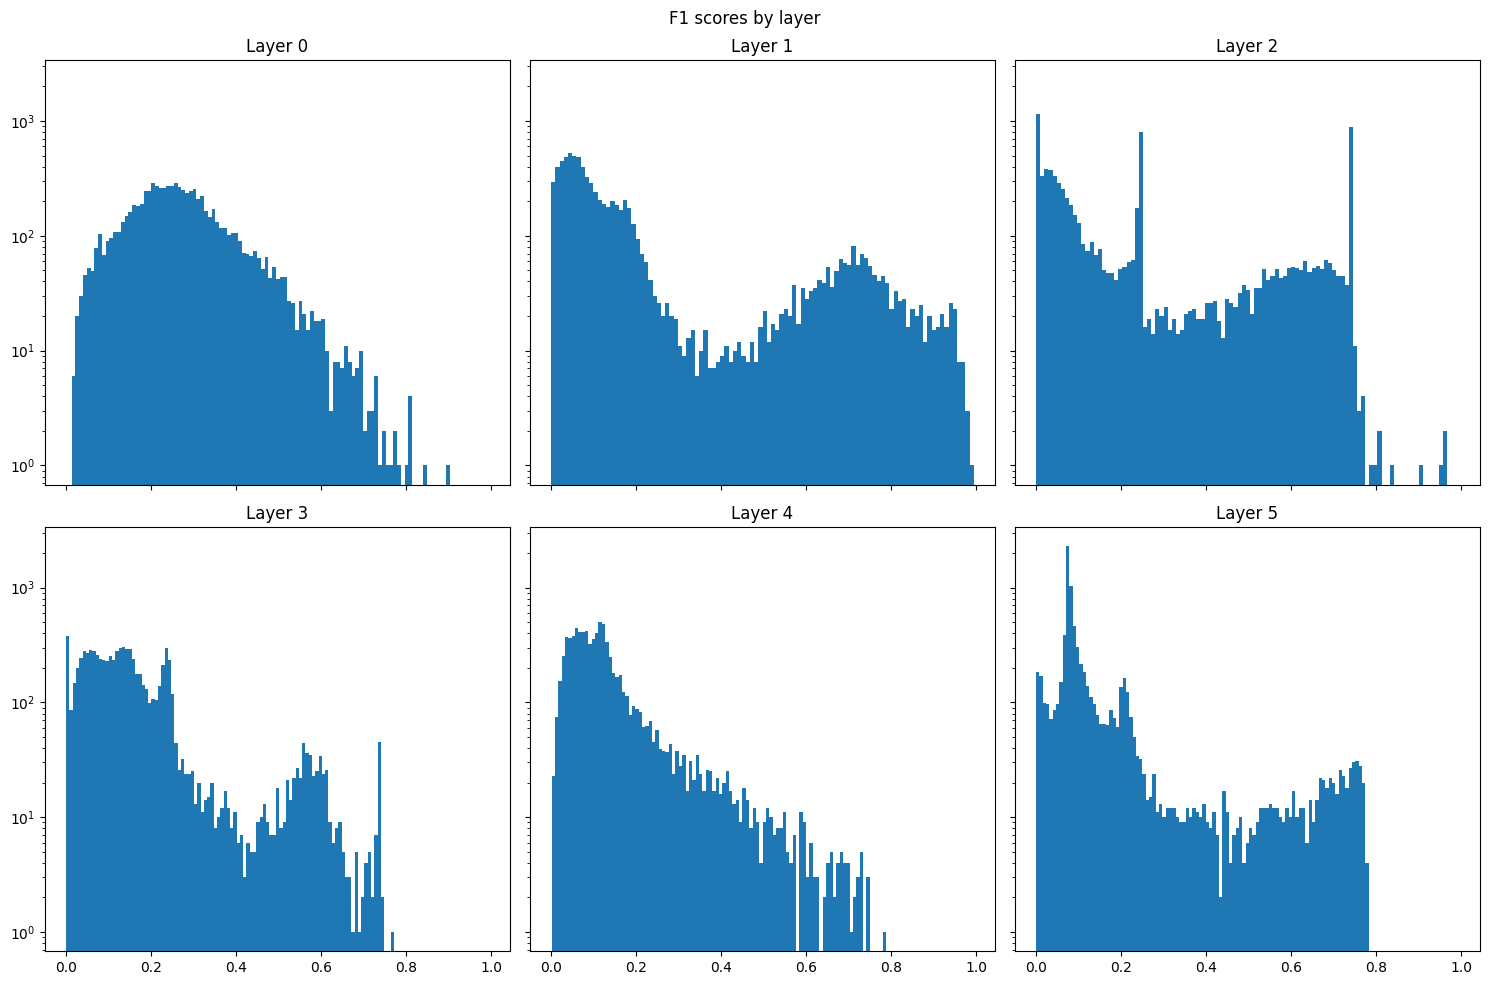

In [6]:
# F1 scores
fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharey=True, sharex=True)
ax = ax.flatten()
for dim in range(6):
    ax[dim].hist(lin.f1_scores[f"{dim}/{SAE_NUM}"]["f1_scores"], bins=100)
    ax[dim].set_title(f"Layer {dim}")
    ax[dim].set_yscale("log")

plt.suptitle("F1 scores by layer")
plt.tight_layout()
plt.show()

In [7]:
# Top token distributions

top_tokens_by_layer = pd.DataFrame()
for layer in range(6):
    top_tokens = Counter(lin.f1_scores[f"{layer}/{SAE_NUM}"]["top_tokens"]).most_common(10)
    top_tokens_by_layer[f"{layer} token"] = [x[0] for x in top_tokens]
    top_tokens_by_layer[f"{layer} count"] = [x[1] for x in top_tokens]

top_tokens_by_layer

,0 token,0 count,1 token,1 count,2 token,2 count,3 token,3 count,4 token,4 count,5 token,5 count
0,of,2395,<|endoftext|>,1669,<|endoftext|>,2547,.,2677,.,2410,\n,3615
1,<|endoftext|>,881,.,1657,.,1451,<|endoftext|>,1599,\n,2049,.,1694
2,.,805,,457,None,858,\n,1596,<|endoftext|>,1897,<|endoftext|>,1290
3,",",791,or,352,of,608,",",636,the,415,the,614
4,to,550,’,182,-,531,-,253,-,382,-,269
5,the,485,\n,151,\n,511,of,246,",",366,",",253
6,a,428,-,138,to,157,the,240,_,82,�,201
7,\n,289,of,132,ref,134,None,148,".""",77,to,40
8,-,157,",",91,",",132,and,138,’,64,of,20
9,2,123,ref,90,the,115,"""",115,a,59,MAP,20


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


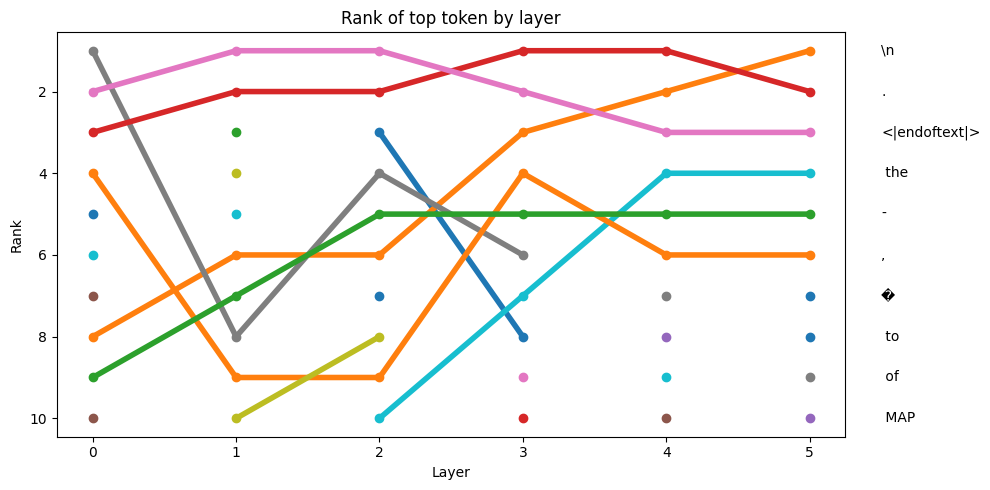

In [8]:
# Make a line graph showing the relative positions of tokens (ChatGPT)


# Transform the DataFrame to have 'token', 'layer', and 'rank'
data = []
for layer in range(6):
    tokens = top_tokens_by_layer[f"{layer} token"]
    counts = top_tokens_by_layer[f"{layer} count"]
    for rank, (token, count) in enumerate(zip(tokens, counts), start=1):
        data.append({"token": token, "layer": layer, "rank": rank})

# Create a new DataFrame
ranked_tokens_df = pd.DataFrame(data)

pivot_df = ranked_tokens_df.pivot(index="layer", columns="token", values="rank")

plt.figure(figsize=(10, 5))

# Plot each token with a label at the end
for token in pivot_df.columns:
    plt.plot(pivot_df.index, pivot_df[token], marker="o", lw=4)
    # Add text label at the end of each line
    end_x = pivot_df.index[-1] + 0.5  # Slightly right of the last data point
    end_y = pivot_df[token].iloc[-1]  # Y-value at the last data point
    if token == "\n":
        token = "\\n"
    plt.text(end_x, end_y, token, verticalalignment="center")

plt.gca().invert_yaxis()  # Rank 1 at the top
plt.title("Rank of top token by layer")
plt.xlabel("Layer")
plt.ylabel("Rank")
plt.xticks(range(6))  # Assuming there are 6 layers as per the initial example
plt.tight_layout()  # Adjust layout to not cut off labels

plt.show()

# Connections between layers

  0%|          | 0/36 [00:00<?, ?it/s]/tmp/ipykernel_1469039/893790858.py:28: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axs[layer1, layer2].set_ylim(0, torch_hist.max().cpu() * 4)
100%|██████████| 36/36 [00:02<00:00, 16.70it/s]

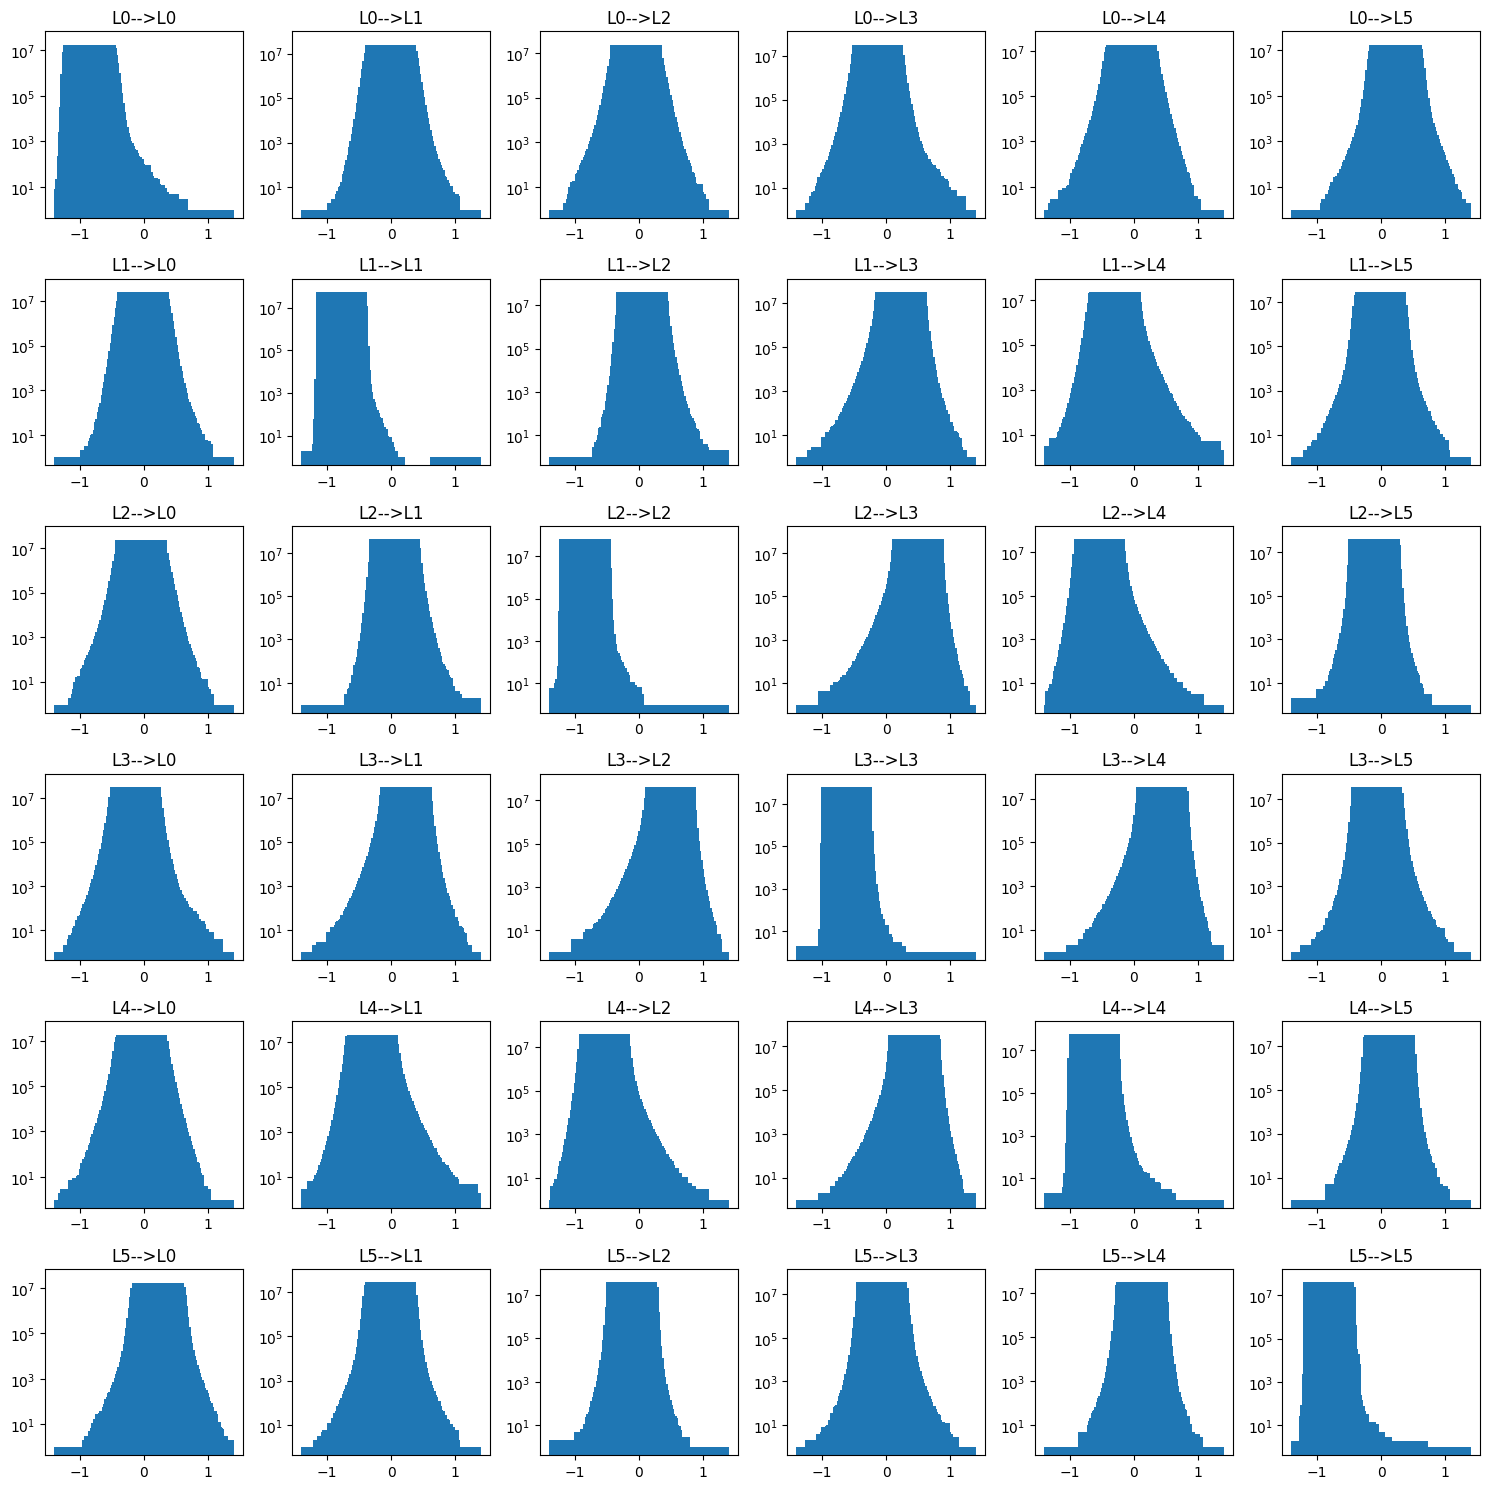

In [55]:
# Pairwise encoder-decoder dot products [weights based]:

fig, axs = plt.subplots(6, 6, figsize=(15, 15))
my_tqdm = tqdm(total=36)

with torch.no_grad():
    for layer1 in range(6):
        for layer2 in range(6):
            enc = lin.saes[f"{layer1}/{SAE_NUM}"].W_enc.to(DEVICE)
            dec = lin.saes[f"{layer2}/{SAE_NUM}"].W_dec.to(DEVICE)

            if NORMALIZE_SAE_VECS:
                enc = torch.nn.functional.normalize(enc, p=2, dim=1)
                dec = torch.nn.functional.normalize(dec, p=2, dim=0)

            # Compute pairwise dot-products and drop infinite values
            dot = (dec @ enc).flatten().to(torch.float32)
            torch_hist = torch.histc(dot)

            if NORMALIZE_SAE_VECS:
                xmin, xmax = -1, 1
            else:
                xmin, xmax = dot.min().cpu(), dot.max().cpu()

            axs[layer1, layer2].bar(np.linspace(xmin, xmax, len(torch_hist)), torch_hist.cpu())
            axs[layer1, layer2].set_yscale("log")
            axs[layer1, layer2].set_title(f"L{layer1}-->L{layer2}")
            axs[layer1, layer2].set_ylim(0, torch_hist.max().cpu() * 4)
            my_tqdm.update(1)

plt.tight_layout()

# Connections between expansion factors